## Load Dependencies

In [17]:
%matplotlib notebook

import math
import torch
import torch.nn as nn
import numpy as np
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, sampler
from torchvision import transforms, utils
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn import metrics


from libs.data_utils import HandDataset, ToTensor, Scale, GestureDataset
from libs.layer_utils import flatten, random_weight, zero_weight
from libs.model_utils import (show_joints, makePosList, makePosListBatch,
                              makeHeatMapOneHot, makeMaps, generate_blw, 
                              ComputeLoss, get_loss, load_model, save_model,
                             compute_g_loss)
from libs.model import model, modelHeatmap, modelLocmap, fc, norm5d
from libs.lit_data import data2d, data3d, data3d2
from libs.misc import write_log
                              
plt.ion() # interactive mode

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define Parameters

In [18]:
params = {}

USE_GPU = False
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    USE_GPU=False
print('Using device:', device)

batch_size = 15
num_joints = 21
image_size = 224
dtype = torch.float32
g_heatmap_size = 9

b_idx = np.repeat(np.arange(batch_size), num_joints)
b_idx = torch.from_numpy(b_idx).long()
j_idx = np.array(list(np.arange(num_joints))*batch_size)
j_idx = torch.from_numpy(j_idx).long()

params['batch_size'] = batch_size
params['num_joints'] = num_joints
params['image_size'] = image_size
params['dtype'] = dtype
params['device'] = device
params['USE_GPU'] = USE_GPU
params['g_heatmap_size'] = 9
params['b_idx'] = b_idx
params['j_idx'] = j_idx

blw = generate_blw(params)

Using device: cpu


## Load Dataset

In [19]:
transform = transforms.Compose([
    Scale(image_size, image_size),
    ToTensor(),
])

g_dataset = GestureDataset('gesture_dataset.csv', transform=transform, train=True)
N = len(g_dataset)

loader_g_train = DataLoader(g_dataset, batch_size=batch_size,
            sampler=sampler.SubsetRandomSampler(range(int(N*0.8))),
            drop_last=True)

loader_g_val = DataLoader(g_dataset, batch_size=batch_size,
            sampler=sampler.SubsetRandomSampler(range(int(N*0.8), int(N*0.9))),
            drop_last=True)

loader_g_test = DataLoader(g_dataset, batch_size=batch_size,
            sampler=sampler.SubsetRandomSampler(range(int(N*0.9),N)),
            drop_last=True)


## Load Model

**Fully Connected Layer to Predict Gesture**

Input: The outputs of our joint prediction model outputs:

p2d: # size (N, 21, 2)
p3d: # size (N, 21, 3)

Output:

y: # size (N, C=10), where C is the number of gesture classes

**Note:** We will use both the 2D positions and the 3D positions of the joints to figure out what the gesture is

In [20]:
fp_head = 'models'
fp_tail = '_e3_i7800'

model, modelHeatmap, modelLocmap, _ = load_model(model,
    modelHeatmap, modelLocmap, None, fp_head, fp_tail, params)

for param in model.parameters():
    param.requires_grad = False
for param in modelHeatmap.parameters():
    param.requires_grad = False
for param in modelLocmap.parameters():
    param.requires_grad = False
    


## Train model

### Define additional params

In [21]:
# important, swith the joint prediction network to eval mode
model.eval()
modelHeatmap.eval()
modelLocmap.eval()

if USE_GPU:
    model = model.cuda()
    modelHeatmap = modelHeatmap.cuda()
    modelLocmap = modelLocmap.cuda()
    fc = fc.cuda()
    norm5d = norm5d.cuda()

print_every = 50
save_every = 5000
eval_every = 5000

trainlog_fp = 'g_trainlog.txt'
vallog_fp = 'g_vallog.txt'

g_optimizer = torch.optim.Adam(fc.parameters(), lr=1.0e-3)

### Training!

In [ ]:
for epoch in range(20):
    print("Epoch: {}".format(epoch))
    for idx, batch in enumerate(loader_g_train):
        image = batch['image'].float()
        if USE_GPU:
            image = image.cuda()
        y_pred = model(image)
        h_pred = modelHeatmap(y_pred)
        l_pred = modelLocmap(y_pred)
        
        h_pred = h_pred.cpu()
        l_pred = l_pred.cpu()
        p2d, p3d = makePosListBatch(h_pred, l_pred, params)
        
        """
        p2d = p2d[0]
        p3d = p3d[0]
        img_npy = image[0].cpu().numpy()
        img_npy = img_npy.transpose(1,2,0)
        """
        g_loss, _ = compute_g_loss(fc, norm5d, p2d, p3d, batch['label'], params)
        g_loss.backward()
        g_optimizer.step()
        g_optimizer.zero_grad()
        
        if idx % print_every == 0:
            print("training_loss: ", g_loss)
        
        with open(trainlog_fp, 'a') as f:
            f.write("{}, {}, {}\n".format(epoch, idx, g_loss))
        
        if idx % eval_every == 0:
            with torch.no_grad():
                val_loss = []
                for vidx, vbatch in enumerate(loader_g_val):
                    image = batch['image'].float()
                    if USE_GPU:
                        image = image.cuda()
                    y_pred = model(image)
                    h_pred = modelHeatmap(y_pred)
                    l_pred = modelLocmap(y_pred)
                    
                    h_pred = h_pred.cpu()
                    l_pred = l_pred.cpu()
                    p2d, p3d = makePosListBatch(h_pred, l_pred, params)
                    
                    vg_loss, _ = compute_g_loss(fc, norm5d, p2d, p3d, batch['label'], params)
                    val_loss.append(vg_loss.data.cpu().numpy())
                val_loss = np.mean(val_loss)
            with open(vallog_fp, 'a') as f:
                f.write("{}, {}, {}\n".format(epoch, idx, val_loss))
                print("{}, {}, {}".format(epoch, idx, val_loss))
        
        if idx % save_every == 0:
            torch.save(fc.state_dict(), 'fc_param_e{}_i{}.pt'.format(epoch, idx))
            torch.save(norm5d.state_dict(), 'norm5d_param_e{}_i{}.pt'.format(epoch, idx))
            torch.save(g_optimizer.state_dict(), 'g_optimizer_param_e{}_i{}.pt'.format(epoch, idx))


In [95]:
torch.save(fc.state_dict(), 'fc_param.pt'.format(18, 0))
torch.save(norm5d.state_dict(), 'norm5d_param.pt'.format(18, 0))
torch.save(g_optimizer.state_dict(), 'g_optimizer_param.pt'.format(18, 0))

## Evaluation

In [23]:
fp_head = '.'
fp_tail = '_e18_i0' #'_e15_i0'

fc.load_state_dict(torch.load('{}/fc_param{}.pt'.format(fp_head, fp_tail), map_location=lambda storage, loc: storage))
norm5d.load_state_dict(torch.load('{}/norm5d_param{}.pt'.format(fp_head, fp_tail), map_location=lambda storage, loc: storage))


In [29]:
# The confusion matrix
confusion_array = np.zeros((10, 10))
total_test = 0
test_correct = 0
for idx, batch in enumerate(loader_g_test):
    with torch.no_grad():
        image = batch['image'].float()
        batch['label'] = batch['label'].long()
        if USE_GPU:
            image = image.cuda()

        y_pred = model(image)
        h_pred = modelHeatmap(y_pred)
        l_pred = modelLocmap(y_pred)

        h_pred = h_pred.cpu()
        l_pred = l_pred.cpu()
        p2ds, p3ds = makePosListBatch(h_pred, l_pred, params)
        _, g_pred = compute_g_loss(fc, norm5d, p2ds, p3ds, batch['label'], params)
        predicted = np.argmax(g_pred, axis=1)
        total_test = total_test + 15
        test_correct = test_correct + len(predicted[predicted == batch['label']])
        for p, l in zip(predicted, batch['label']):
            confusion_array[l, p] = confusion_array[l, p] + 1
#     for i, img in enumerate(image):
#         p2d, p3d = makePosList(h_pred[i], l_pred[i], params)
#         img_npy = image[i].data.cpu().numpy().transpose((1,2,0))
#         #p2d_gt, p3d_gt = batch['pos_2d'][i], batch['pos_3d'][i]


#         show_joints(img_npy, p2d, p3d)
#     break
print("Prediction accuract on test set: ", test_correct / total_test)
print("Test set size: ", total_test)

Prediction accuract on test set:  0.4166666666666667
Test set size:  120


Generate the Confusion Matrix

<IPython.core.display.Javascript object>


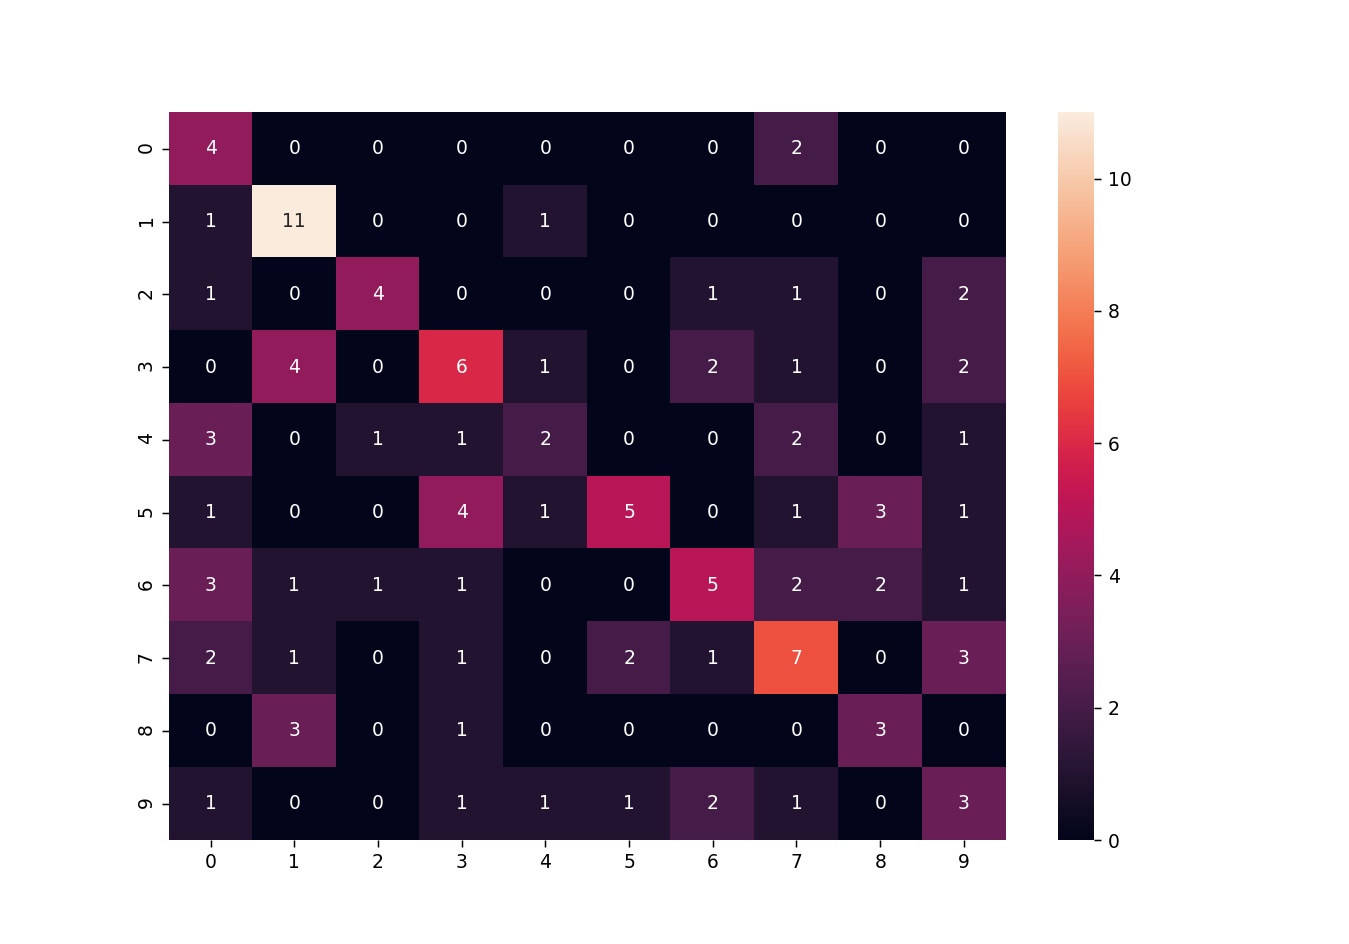

In [31]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(confusion_array, index = [i for i in "0123456789"],
                  columns = [i for i in "0123456789"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [106]:
total_val = 0
val_correct = 0
for idx, batch in enumerate(loader_g_val):
    with torch.no_grad():
        image = batch['image'].float()
        image = image.cuda()

        y_pred = model(image)
        h_pred = modelHeatmap(y_pred)
        l_pred = modelLocmap(y_pred)

        h_pred = h_pred.cpu()
        l_pred = l_pred.cpu()
        p2ds, p3ds = makePosListBatch(h_pred, l_pred, params)
        _, g_pred = compute_g_loss(fc, norm5d, p2ds, p3ds, batch['label'], params)
        predicted = np.argmax(g_pred, axis=1)
        total_val = total_val + 15
        print(len(predicted[predicted == batch['label']]))
        val_correct = val_correct + len(predicted[predicted == batch['label']])
    
#     for i, img in enumerate(image):
#         p2d, p3d = makePosList(h_pred[i], l_pred[i], params)
#         img_npy = image[i].data.cpu().numpy().transpose((1,2,0))
#         #p2d_gt, p3d_gt = batch['pos_2d'][i], batch['pos_3d'][i]


#         show_joints(img_npy, p2d, p3d)
#     break
print("Prediction accuract on val set: ", val_correct / total_val)

7
5
8
7
5
5
3
6
Prediction accuract on val set:  0.38333333333333336


In [107]:
total_train = 0
train_correct = 0
for idx, batch in enumerate(loader_g_val):
    with torch.no_grad():
        image = batch['image'].float()
        image = image.cuda()

        y_pred = model(image)
        h_pred = modelHeatmap(y_pred)
        l_pred = modelLocmap(y_pred)

        h_pred = h_pred.cpu()
        l_pred = l_pred.cpu()
        p2ds, p3ds = makePosListBatch(h_pred, l_pred, params)
        _, g_pred = compute_g_loss(fc, norm5d, p2ds, p3ds, batch['label'], params)
        predicted = np.argmax(g_pred, axis=1)
        total_train = total_train + 15
        print(len(predicted[predicted == batch['label']]))
        train_correct = train_correct + len(predicted[predicted == batch['label']])
    
#     for i, img in enumerate(image):
#         p2d, p3d = makePosList(h_pred[i], l_pred[i], params)
#         img_npy = image[i].data.cpu().numpy().transpose((1,2,0))
#         #p2d_gt, p3d_gt = batch['pos_2d'][i], batch['pos_3d'][i]


#         show_joints(img_npy, p2d, p3d)
#     break
print("Prediction accuract on train set: ", train_correct / total_train)

6
7
6
4
3
9
5
6
Prediction accuract on train set:  0.38333333333333336
